# Diamonds Data Analysis

## 1. Introduction 
![Alt text](https://storage.googleapis.com/kaggle-datasets-images/3789686/6558930/1dd5c908903a788e54a5b5a608c282bf/dataset-cover.jpg?t=2023-09-28-02-27-42)
(Source: https://kaggle.com/datasets/joebeachcapital/diamonds/)

Diamonds have long been revered for their exquisite beauty, rarity, and intrinsic value. From engagement rings to heirloom jewelry, the allure of diamonds transcends time and culture. Yet, what gives a diamond its unique attributes, such as its brilliance, fire, and scintillation, is a complex interplay of various characteristics. Understanding how these factors influence a diamond's quality and value is not just a matter of gemology but an intriguing data-driven challenge that can revolutionize the diamond industry. Our project aims to answer to predict questions based on the diamonds.csv data set using the classification technique. This data set contains information on the carats, cut, color, clarity, depth, table, price, x, y, and z dimensions of 53,940 diamonds.


![Alt text](https://raw.githubusercontent.com/sadrakhosravi/g1-dsci-project/main/diamond_image.jpg)

A carat is the unit of measurement for the physical weight of a diamond and in this data set, it ranges from 0.2 to 5.01. The cut of the diamond is how well proportioned the dimensions are and the way the surfaces are positioned to give the diamond its sparkle and is categorized as fair, good, very good, premium, and ideal. The color column in the data set refers to the color grade of the diamond which ranges from J (the worst) to D (the best). The clarity of the diamond is based on the visual appearances such as inclusions and includes values such as I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, and IF (best). The table column refers to the width of each diamond from the top to the widest point ranging from 43 to 95. The depth column refers to the total depth percentage of the diamond which is calculated by dividing the depth of the diamond by the mean of its length and its width. The x,y, and z dimensions refer to the length, width, and depth of the diamonds in mm respectively. This data set contains all the external characteristics visible from a diamond and is thus used as the focus of our project. By leveraging cutting-edge analytical tools, we can assist jewelers, traders, and enthusiasts in making informed decisions about diamond purchases.


The question we would like to answer is if the cut of the diamond can be predicted using quantitative variables such as the carat, price, total depth percentage, table, and the length, width, and depth of the diamond.

## 2. Data Preparation and Tidying

### 2.1 Data Prepration 

In [57]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [58]:
# Reading in the data set
url <- "https://raw.githubusercontent.com/sadrakhosravi/g1-dsci-project/main/diamonds.csv"

diamond_data <- read_csv("https://raw.githubusercontent.com/sadrakhosravi/g1-dsci-project/main/diamonds.csv")

# Tidy the data by making the cut a factor, changing color names to colorless and faint color, changing column names, and only selecting data needed.
diamond_data <- diamond_data |>
                 mutate(cut = as_factor(cut)) |>   # making cut a factor
                 mutate(color = fct_recode(color, "Colorless" = "D", "Colorless" = "E", "Colorless" = "F" , "Faint Color" = "G", "Faint Color" = "H",
                                           "Faint Color" = "I", "Faint Color" = "J")) |>  # changing names to correspond with color
                 rename(length = x, width = y, depth = z, total_depth_percentage = depth) |> # renaming column names
                 select(carat:color, total_depth_percentage:depth)  # taking out data not needed (clarity)
diamond_data

# Split diamond_data into training and test data
diamond_split <- initial_split( diamond_data, prop = 0.75, strata = cut)
diamond_train <- training(diamond_split)
diamond_test <- testing(diamond_split)


Rows: 53940 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): cut, color, clarity
dbl (7): carat, depth, table, price, x, y, z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


carat,cut,color,total_depth_percentage,table,price,length,width,depth
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,Colorless,61.5,55,326,3.95,3.98,2.43
0.21,Premium,Colorless,59.8,61,326,3.89,3.84,2.31
0.23,Good,Colorless,56.9,65,327,4.05,4.07,2.31
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.70,Very Good,Colorless,62.8,60,2757,5.66,5.68,3.56
0.86,Premium,Faint Color,61.0,58,2757,6.15,6.12,3.74
0.75,Ideal,Colorless,62.2,55,2757,5.83,5.87,3.64


### 2.2 Basic Data Summary

In [59]:
# Find proportions of each different type of cut based on training data. Also identifies if there are any NA's that need to be filtered out
diamond_proportions <- diamond_train |>
                      group_by(cut) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(diamond_train))

print("The number of observations for each class (cut)")
diamond_proportions

[1] "The number of observations for each class (cut)"


cut,n,percent
<fct>,<int>,<dbl>
Ideal,16156,39.936718
Premium,10390,25.683492
Good,3669,9.069560
Very Good,9055,22.383448
Fair,1184,2.926781


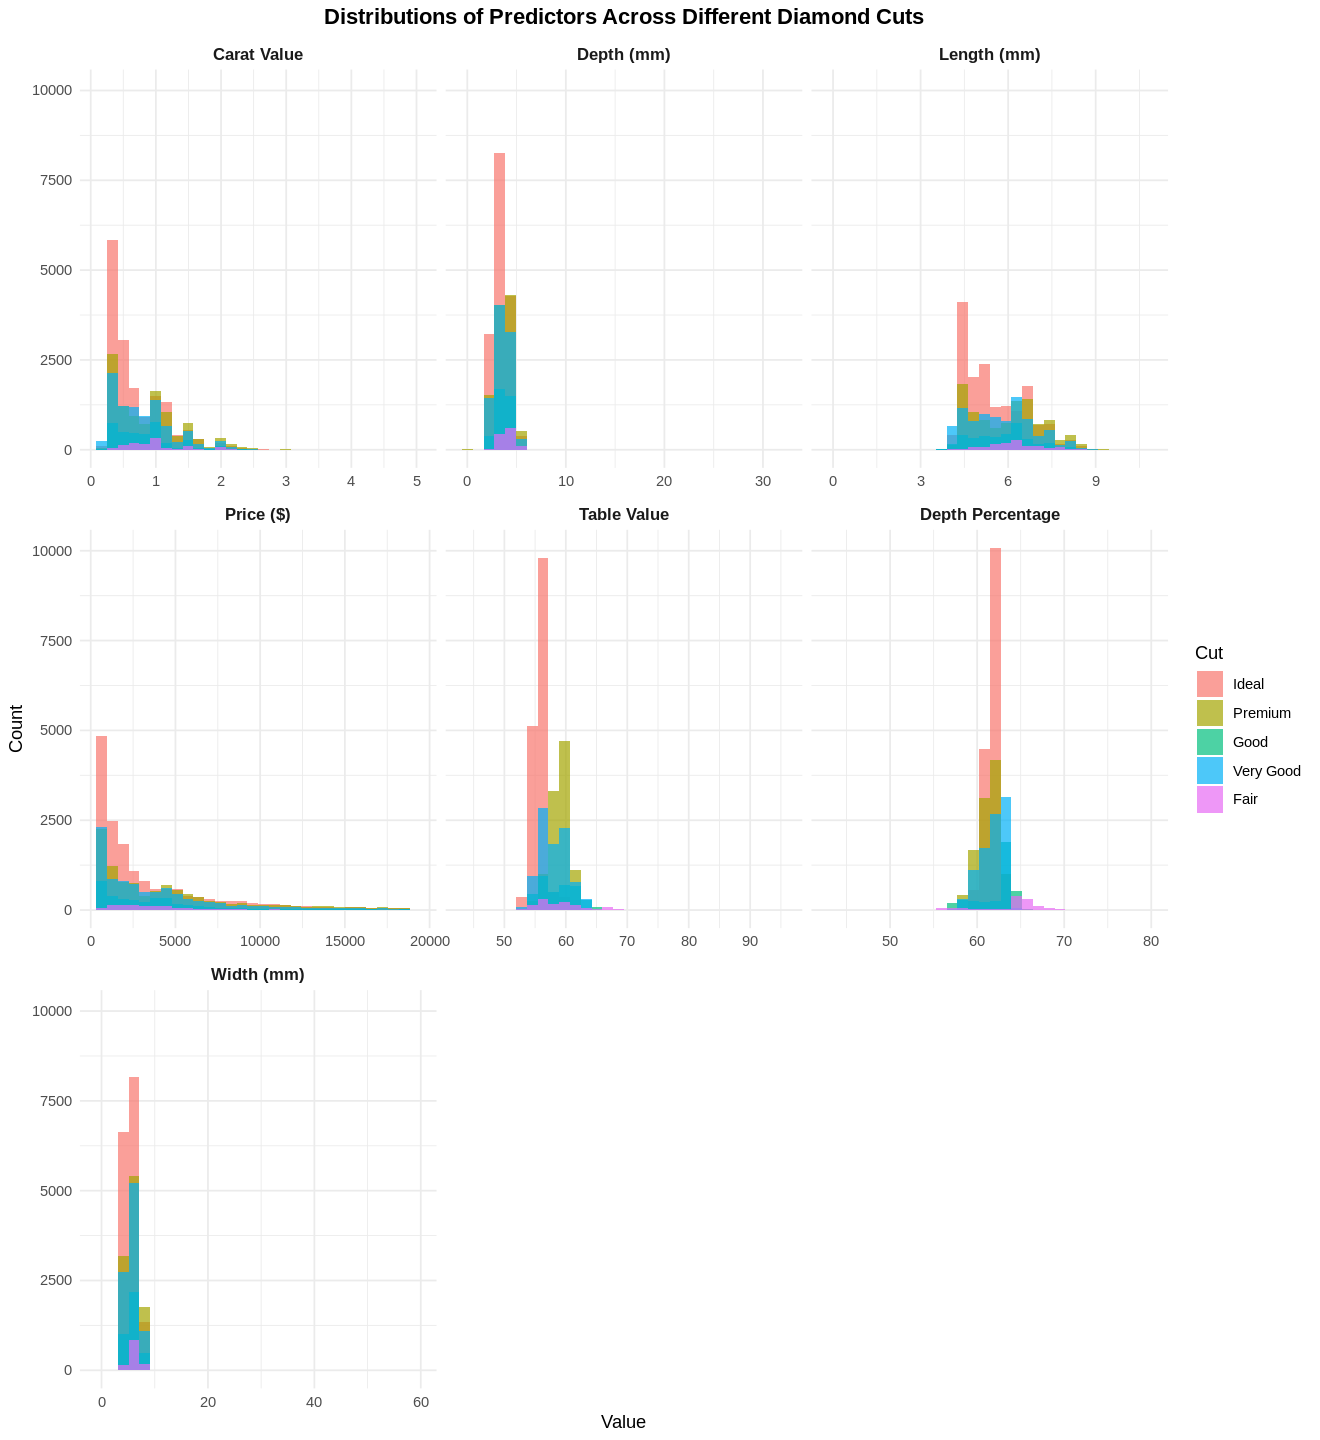

In [60]:
# Show the distribution of predictors accross different diamond cuts
options(repr.plot.width = 11, repr.plot.height = 12) # you can change the size of the plot if it is too small or too large 

# Get the relevant columns
diamond_long <- diamond_train |>
  select(cut, carat, price, total_depth_percentage, table, length, width, depth) |>
  gather(key = "variable", value = "value", -cut)

labels <- as_labeller(c(carat = "Carat Value",
                               price = "Price ($)",
                               total_depth_percentage = "Depth Percentage",
                               table = "Table Value",
                               length = "Length (mm)",
                               width = "Width (mm)",
                               depth = "Depth (mm)"))

dist_plot <- ggplot(diamond_long, aes(x = value, fill = cut)) +
  geom_histogram(alpha = 0.7, position = "identity", bins=30) +
  facet_wrap(~ variable, scales = "free_x", labeller = labels) +
  labs(x = "Value", y = "Count", fill = "Cut") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face="bold"),
    strip.text = element_text(face = "bold", size = 10),
    strip.background = element_blank()
  ) +
  ggtitle("Distributions of Predictors Across Different Diamond Cuts")

dist_plot

## 3. Method
Our approach involves a systematic process of designing and analyzing functions and visualizations.

Our approach involves a systematic process. First, we a recipe must be created to select the predictors and make sure all variables are on the same scale. The next step is to randomly divide the data into a training set and a test set. We then set up the model and combine it with the recipe in line with our workflow. To determine the optimal 'k' value for each model, we use cross-validation on the training data, testing different 'k' values to find the model with the highest accuracy. Once we've found the 'k' value for each model, the final step is to use the test data to calculate the actual accuracy. To identify which model performs best in classifying diamond cuts, we can create a bar chart to visually compare their accuracy.

In our selection of predictors, we initiated the process by creating individual histograms for each quantitative variable and color-coded them according to the various diamond cut categories. After checking all these graphs, we confirmed that every quantitative variable exhibited a positive relationship with the cut of the diamond. Consequently, we made the informed choice to include all variables associated with quantity, such as carat, depth, table, and price, and the diamond's dimensions, encompassing width, height, and length. These variables collectively form the foundation for predicting the cut of the diamond.

## 4. Expected Outcomes and Significance
Our objective is to develop the most accurate predictive model for categorizing the cut of diamonds, employing three different predictive models. This breakthrough will greatly simplify the process of assessing the quality of diamond cuts, empowering individuals to easily gauge the excellence of a diamond before involving an official grading center. Moreover, this innovation will enable gemstone companies to significantly reduce costs by preventing the certification of poorly cut gemstones, thus avoiding unnecessary expenses. Looking forward, we envision our model becoming a versatile tool used in the prediction of cuts for various types of jewels, further enhancing its utility and impact across the jewelry industry.